Epoch 0, Loss: 47.686775
Epoch 500, Loss: 15.989772
Epoch 1000, Loss: 13.047709
Epoch 1500, Loss: 12.021077
Epoch 2000, Loss: 11.720990
Epoch 2500, Loss: 9.810742
Epoch 3000, Loss: 9.668013
Epoch 3500, Loss: 9.743118
Epoch 4000, Loss: 7.825917
Epoch 4500, Loss: 8.770867
Epoch 5000, Loss: 8.102366
Epoch 5500, Loss: 6.802330
Epoch 6000, Loss: 7.291070
Epoch 6500, Loss: 7.657029
Epoch 7000, Loss: 8.106937
Epoch 7500, Loss: 6.694079
Epoch 8000, Loss: 7.004592
Epoch 8500, Loss: 8.400894
Epoch 9000, Loss: 7.662223
Epoch 9500, Loss: 6.596858


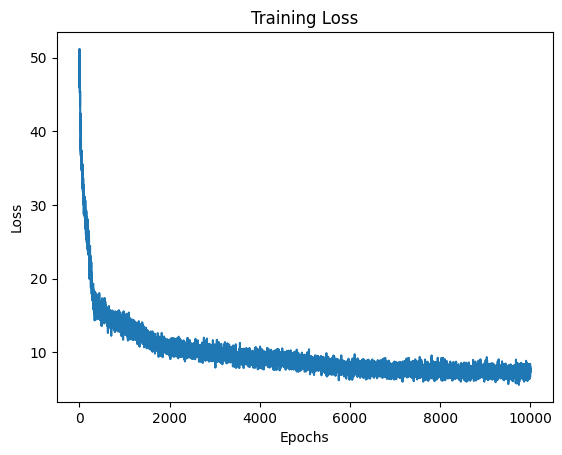

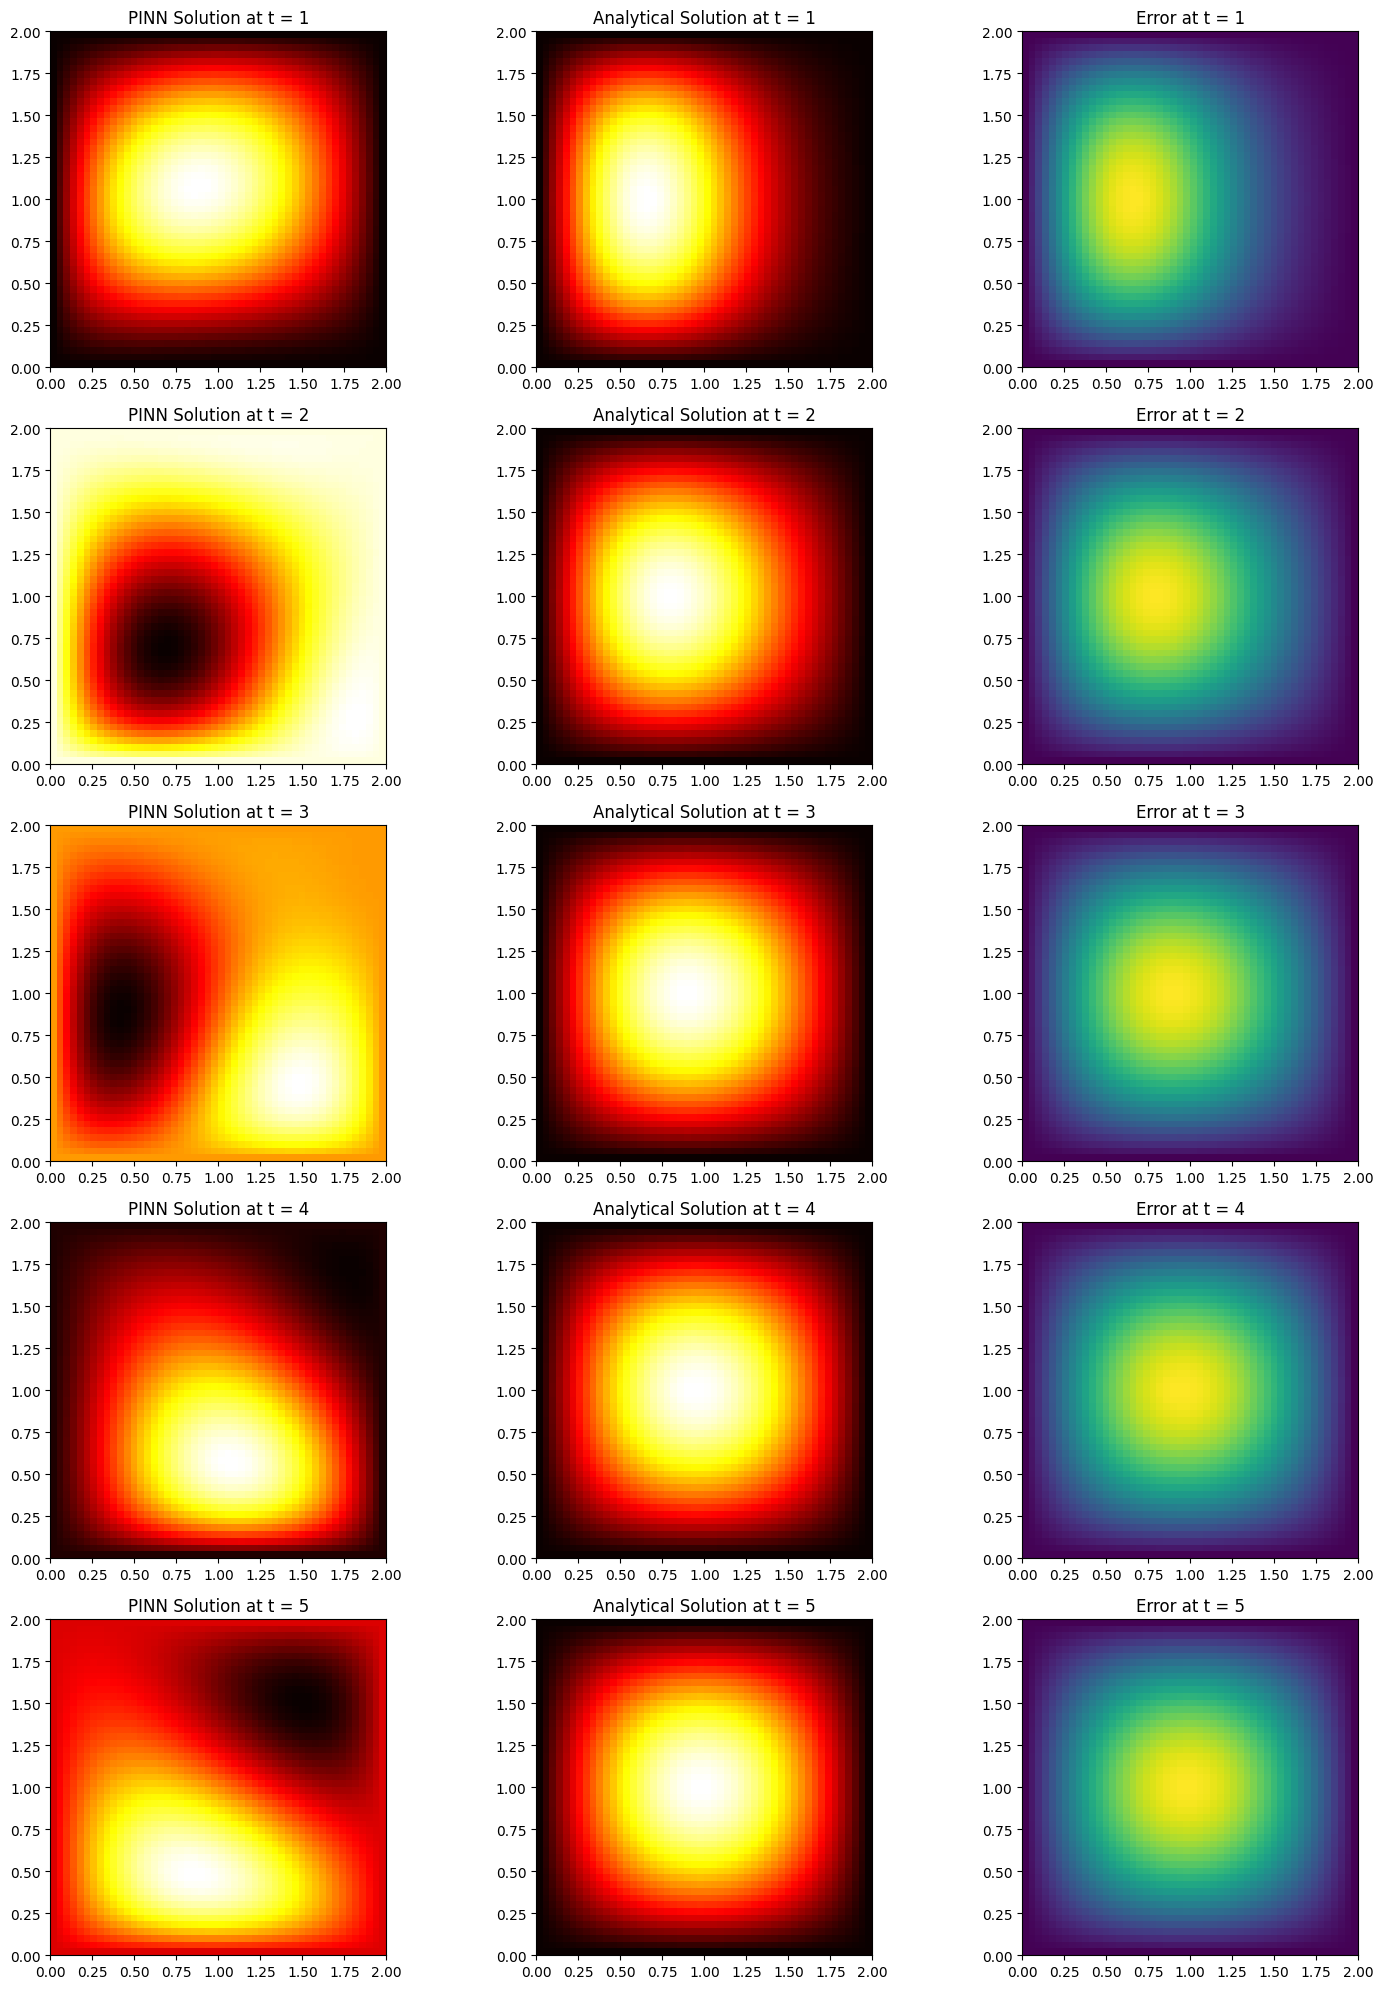

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
alpha = 1 / 3  # Thermal diffusivity constant
a, b = 2, 2  # Plate dimensions
n_epochs = 10000
n_points = 2000

# Define initial condition
def initial_temperature(x, y):
    """Normalized initial condition: 1 for y <= 1, else 0."""
    return torch.where(y <= 1, torch.tensor(1.0), torch.tensor(0.0))

# Analytical solution for comparison
def analytical_solution(x, y, t, terms=50):
    """Analytical solution to the 2D heat equation."""
    u = 0
    for m in range(1, terms + 1):
        for n in range(1, terms + 1):
            coeff = 200 / (np.pi**2 * m * n) * (1 + (-1)**(m + 1)) * (1 - np.cos(n * np.pi / 2))
            lambda_mn = (np.pi / 6) * np.sqrt(m**2 + n**2)
            u += coeff * np.sin(m * np.pi * x / a) * np.sin(n * np.pi * y / b) * np.exp(-lambda_mn**2 * t)
    return 50 * u  # Scale back to the actual temperature

# Define PINN model
class PINN2DHeat(nn.Module):
    def __init__(self):
        super(PINN2DHeat, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 256),  # Input: x, y, t
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 1)  # Output: u(x, y, t)
        )

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        u = self.net(inputs)
        # Enforce boundary conditions: u(x, y, t) = 0 on edges
        return x * (a - x) * y * (b - y) * u

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

# Define the PDE residual
def heat_equation_residual(model, x, y, t, alpha):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, y, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
    return u_t - alpha * (u_xx + u_yy)

# Boundary and initial condition losses
def initial_condition_loss(model, x, y):
    t_zero = torch.zeros_like(x)
    u_pred = model(x, y, t_zero)
    u_true = initial_temperature(x, y)
    return torch.mean((u_pred - u_true)**2)

# Training function
def train_pinn(model, optimizer, scheduler, n_epochs, n_points):
    loss_history = []
    for epoch in range(n_epochs):
        # Sample points in the domain
        x = torch.rand((n_points, 1)) * a
        y = torch.rand((n_points, 1)) * b
        t = torch.rand((n_points, 1)) * 5

        # PDE residual loss
        loss_pde = torch.mean(heat_equation_residual(model, x, y, t, alpha)**2)

        # Initial condition loss
        x_init = torch.rand((n_points // 2, 1)) * a
        y_init = torch.rand((n_points // 2, 1)) * b
        loss_ic = initial_condition_loss(model, x_init, y_init)

        # Weighted total loss
        loss = 1.0 * loss_pde + 100.0 * loss_ic

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return loss_history

# Train the model
model = PINN2DHeat()
model.apply(xavier_init)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

loss_history = train_pinn(model, optimizer, scheduler, n_epochs, n_points)

# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Compare PINN and Analytical Solution for t = 1, 2, 3, 4, 5
time_steps = [1, 2, 3, 4, 5]
x_vals = torch.linspace(0, a, 50).reshape(-1, 1)
y_vals = torch.linspace(0, b, 50).reshape(-1, 1)
X, Y = torch.meshgrid(x_vals.squeeze(), y_vals.squeeze())

fig, axes = plt.subplots(len(time_steps), 3, figsize=(15, 20))

for i, t_fixed in enumerate(time_steps):
    t_tensor = torch.full_like(X.reshape(-1, 1), t_fixed)
    u_pred = model(X.reshape(-1, 1), Y.reshape(-1, 1), t_tensor).detach().numpy()
    u_exact = analytical_solution(X.numpy(), Y.numpy(), t_fixed, terms=50).reshape(-1, 1)
    error = np.abs(u_pred - u_exact)

    axes[i, 0].imshow(u_pred.reshape(50, 50), extent=[0, a, 0, b], origin='lower', cmap='hot')
    axes[i, 0].set_title(f"PINN Solution at t = {t_fixed}")

    axes[i, 1].imshow(u_exact.reshape(50, 50), extent=[0, a, 0, b], origin='lower', cmap='hot')
    axes[i, 1].set_title(f"Analytical Solution at t = {t_fixed}")

    axes[i, 2].imshow(error.reshape(50, 50), extent=[0, a, 0, b], origin='lower', cmap='viridis')
    axes[i, 2].set_title(f"Error at t = {t_fixed}")

plt.tight_layout()
plt.show()
